## Tarea 4.2

Se obtuvieron datos de velocidad radial con el espectrógrafo PUCHEROS para 3 candidatos a binarias eclipsantes: HD198044, HD205403 y HD222891. Para estas 3 fuentes se cuenta con mediciones del periodo y de fechas de cuadradatura, las que son detalladas en [Wraight et al. 2012](https://ui.adsabs.harvard.edu/#abs/2012MNRAS.427.2298W/abstract). A partir de los datos obtenidos con PUCHEROS más datos del espectrógrafo [CORALIE](http://obswww.unige.ch/~naef/CORALIE/coralie.html) compararemos estas mediciones con la función de velocidad radial ajustada con los parámetros de Wraight et al. 

Debido a que las mediciones tienen el tiempo expresado en unidades de BJD (Barycentric Julian Date) debemos hacer la conversión a MJD (Modified Julian Date), que es la unidad en la que están expresadas las fechas de cuadratura. La correción BJD se realiza porque hay un desfase en la recepción de la señal, la que depende del lugar en el que se encuentre el observador dentro del sistema solar. De esta manera, se elige como punto de referencia al centro de masa (del sistema solar) y, a partir de este, se realiza el ajuste. Además, la correción tiene un comportamiento sinusoidal y su máxima aplitud corresponde a una correción de aproximadamente 8 minutos (para el caso de la Tierra). En nuestro caso, por simplicidad, omitiremos esta correción y usaremos que BJD = JD, luego convertiremos a MJD. [Referencia](https://en.wikipedia.org/wiki/Barycentric_Julian_Date)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('axes', labelsize=10)
% matplotlib inline

In [2]:
# Extracción de datos
pucheros_data = np.genfromtxt('pucheros.dat', dtype ='float', usecols = (1,2))
pucheros_names = np.genfromtxt('pucheros.dat', dtype ='str', usecols = 0)

coralie_data = np.genfromtxt('coralie.dat', dtype ='float', usecols = (1,2))
coralie_names = np.genfromtxt('coralie.dat', dtype ='str', usecols = 0)
        
def match (target):
    idx1 = np.where(coralie_names == target)[0]
    idx2 = np.where(pucheros_names == target)[0]    
    t1,t2 = coralie_data[idx1], pucheros_data[idx2]
    return np.concatenate((t1,t2))
    
HD198044_data = match('HD198044')
HD205403_data = match('HD205403')
HD222891_data = match('HD222891')

# Conversion de MBJD a MJD
# Columna 1 = tiempos, columna 2 = RVs
HD198044_data[:,0] -= 2400000.5
HD205403_data[:,0] -= 2400000.5
HD222891_data[:,0] -= 2400000.5

==========HD198044==========
Period from Transit: 5.15195 Days
Period from fit: 5.15178257309 Days
Amplitude from fit 28.8427616696 km/s
==========HD205403==========
Period from Transit: 2.4449 Days
Period from fit: 2.4438564746 Days
Amplitude from fit 33.2943732848 km/s
==========HD22281==========
Period from Transit: 1.59495 Days
Period from fit: 1.58864855352 Days
Amplitude from fit 101.704756036 km/s


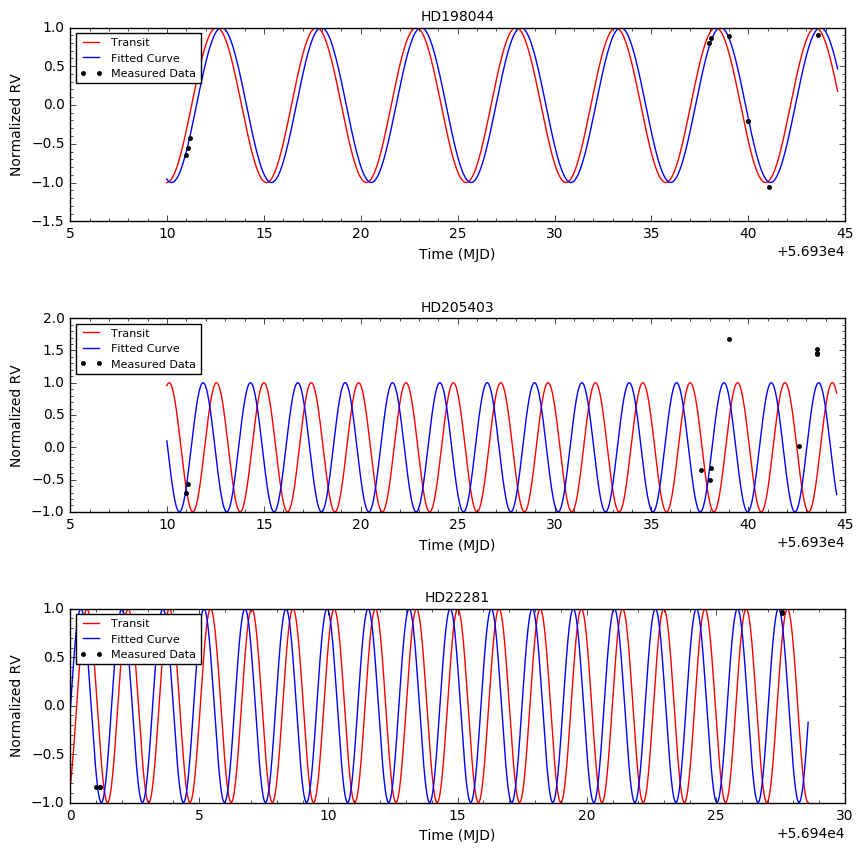

In [29]:
import itertools
from scipy.optimize import leastsq

def sine_curve(A, b, time, phi):
    return A*np.sin(b*time + phi) 

def err(x0):
    A, b, phi = x0
    fit_line = sine_curve(A, b, time, phi)
    return abs((fit_line - RVs)**2)

names = ['HD198044', 'HD205403', 'HD22281']
targets = [HD198044_data, HD205403_data, HD222891_data]

# Parameters from Wraight et al.
quadratures = [54550.509489, 54123.63481, 54150.650434]       # Modified Julian Days
periods = [5.15195, 2.4449, 1.59495]                        

f, ax = plt.subplots(nrows = 3, figsize = [10,10])
for q, p, a, obj, title in itertools.izip(quadratures, periods, ax, targets, names):
    
    time, RVs = obj[:,0], obj[:,1]                             # Times and RVs 
    
    x0 = [np.max(np.absolute(RVs)), (2*np.pi/p), (2*np.pi)*q]  # Guess
    esp_A, esp_b, esp_phi = leastsq(err, x0)[0]                
    
    tmin,tmax = np.min(obj[:,0])-1, np.max(obj[:,0])+1
    time_fit = np.arange(tmin, tmax, 0.0001)
    
    # Fitted curve with Wraight et al. parameters (period and quadrature time)
    b = (2*np.pi/p)
    phi = q*(2*np.pi)
    curve_transit = np.sin(b*time_fit + phi/4.)

    # Fitted curve to data points (pucheros + coralie)
    curve_fit = esp_A*np.sin(esp_b*time_fit + esp_phi) 
    
    a.plot(time_fit, curve_transit, 'r-', label = 'Transit')
    a.plot(time_fit, curve_fit/abs(esp_A), 'b-', label = 'Fitted Curve' )
    a.plot(time, RVs/abs(esp_A), 'k.', label = 'Measured Data')
    a.set_xlabel('Time (MJD)')
    a.set_ylabel('Normalized RV')
    a.set_title(title, fontsize = 10)
    a.legend(loc = 2, prop={'size':8})
    a.minorticks_on() 
    
    print "="*10 + title + "="*10
    print "Period from Transit:", p, "Days" 
    print "Period from fit:", 2*np.pi/esp_b, "Days"
    print "Amplitude from fit", abs(esp_A), "km/s"
f.subplots_adjust(hspace=.5)

# Nota: por alguna razón (que no pude encontrar) leastsq arroja un valor negativo para la amplitud de HD205403.

Los ajustes no son precisos, es necesario una mayor cantidad de datos para conseguir un ajuste más fino. Sin embargo, hemos obtenido resultados cercanos en el caso del periodo.